In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.console import ProgressBar
import warnings
warnings.filterwarnings('ignore')

# Problem 1

## (1) Plot the data versus sample number to see what the raw data look like in time sequence.

In [2]:
data = pd.read_csv('charge.dat')

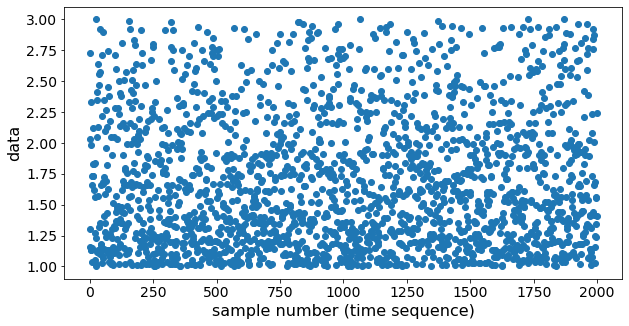

In [3]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,2000),data)
plt.ylabel('data',fontsize=16)
plt.xlabel('sample number (time sequence)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Describe what you see in a sentence or two:

The scatter plot is much more concentrated at the lower end of the y-axis. It looks like there are much more low-energy (1 MeV) photons being detected than high-energy (3 MeV) photons at any given sample number. The number of total photons at any given sample number appears to be uniform throughout the detection period.

## (2) Plot a spectrum proportional to the flux F$\nu$ (photons s$^{−1}$ cm$^{−2}$ MeV$^{−1}$) from the source from 1 MeV to 3 MeV, with equal energy resolution channels across the spectrum of width 0.1 MeV.

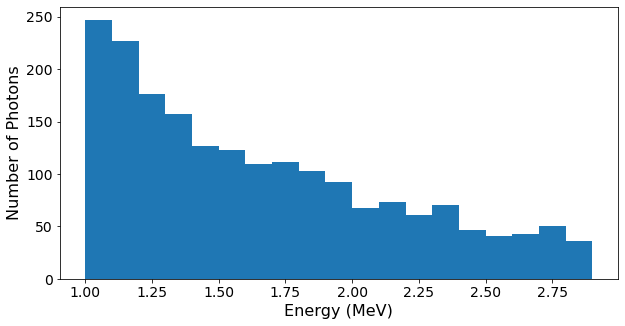

In [4]:
plt.figure(figsize=(10,5))
plt.hist(data,bins=np.arange(1,3,0.1))
plt.ylabel('Number of Photons',fontsize=16)
plt.xlabel('Energy (MeV)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How does this plot explain what you saw in the time sequence?

This plot confirms my suspicions that there are indeed more 1 MeV photons being detected than 3 MeV photons. In fact, there is a decline in photon flux in the range of energies between 1 MeV and 3 MeV. This explains the concentration of points toward the lower end of the y-axis of the time sequence plot.

## (3) Find the value of $\alpha$ from the spectrum.

To convert the power law to a linear fit, take the log of both sides. We know that Fv = E$^{0.7}$E$^{-\alpha}$. Taking the log of both sides, we get: log(Fv) = (0.7-$\alpha$)log(E). Then perform a linear fit (y = mx) where y = log(Fv) and x = log(E).

In [5]:
# Define the histogram, where y = Fv = hist[0] and x = E = hist[1].
hist = np.histogram(data,bins=np.arange(1,3,0.1))

In [6]:
# perform the fit
alpha = (np.polyfit(np.log(hist[1][:19]),np.log(hist[0]),deg=1)[0]-0.7)*-1 # alpha has a negative out in front
print('alpha =', alpha)

alpha = 2.504686662286515


# Problem 2

## (1) Create the master bias.

In [7]:
# get the extensions for the bias frames
bias_frames = np.arange(666,686,step=1)

# create an empty array that will contain the added bias frames
coadd_frames = np.empty((2052,2138))
for ext in bias_frames:
    hdul = fits.open('180206_robo/180206.%s' % ext)
    new_frame = hdul[0].data
    coadd_frames = coadd_frames+new_frame
    
# divide the added bias frames by the number of bias frames (i.e., take the mean)
master_bias = coadd_frames/len(bias_frames)

# write to file
hdu = fits.PrimaryHDU(master_bias)
hdul.writeto('master_bias.fits',overwrite=True)

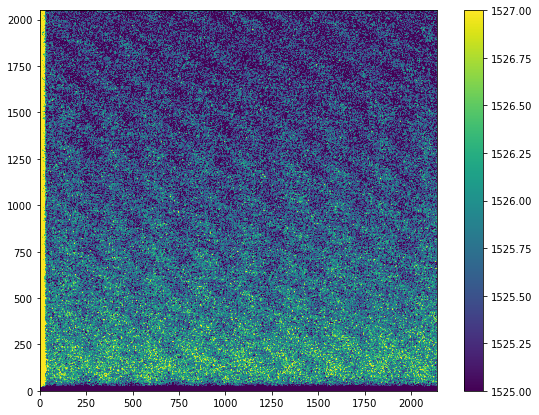

In [8]:
# plot the master bias
image_data = fits.getdata('master_bias.fits', ext=0)
plt.figure(figsize=(10,7))
plt.imshow(image_data, cmap='viridis')
plt.clim(1525, 1527)
plt.colorbar()
plt.ylim(0,2050)
plt.show()

## (2) Create the master flat.

In [9]:
# get the extensions for the twilight flats in R band
twilight_flats1 = np.arange(45,54,step=1)
twilight_flats2 = np.arange(603,612,step=1)
twilight_flats = list(twilight_flats1) + list(twilight_flats2)

In [10]:
flats_data = []
for ext in twilight_flats:
    if ext < 100:
        hdul = fits.open('180206_robo/180206.0%s' % ext)
    else:
        hdul = fits.open('180206_robo/180206.%s' % ext)
    new_frame = hdul[0].data
    flats_data.append(new_frame)
    
# take the median at each pixel between the individual flats
combined_flat = np.median(flats_data, axis=0)

# subtract master bias from combined flat and divide by the median of all the pixels to normalize
master_flat = (combined_flat - master_bias)/np.median(combined_flat)

# write to file
hdu = fits.PrimaryHDU(master_flat)
hdul.writeto('master_flat.fits',overwrite=True)

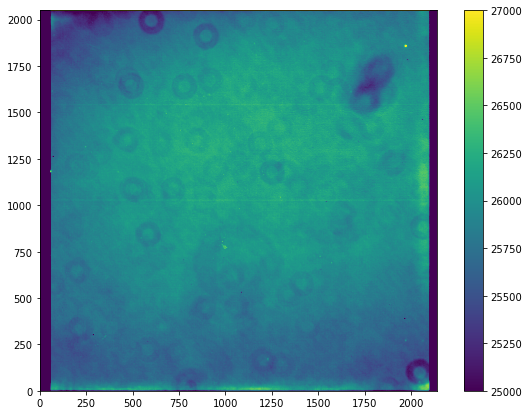

In [11]:
# plot the master flat
image_data = fits.getdata('master_flat.fits', ext=0)
plt.figure(figsize=(10,7))
plt.imshow(image_data, cmap='viridis')
plt.clim(25000, 27000)
plt.colorbar()
plt.ylim(0,2050)
plt.show()

## (3) Calibrate the image.

In [12]:
hdul = fits.open('180206_robo/180206.119')
raw_data = hdul[0].data

calib_data = (raw_data - master_bias)/master_flat

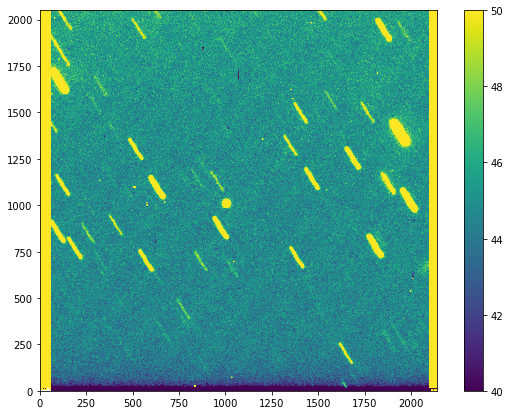

In [13]:
# plot the calibrated data
plt.figure(figsize=(10,7))
plt.imshow(calib_data,cmap='viridis')
plt.clim(40,50)
plt.colorbar()
plt.ylim(0,2050)
plt.show()

## (4) Calculate the source flux and its error.

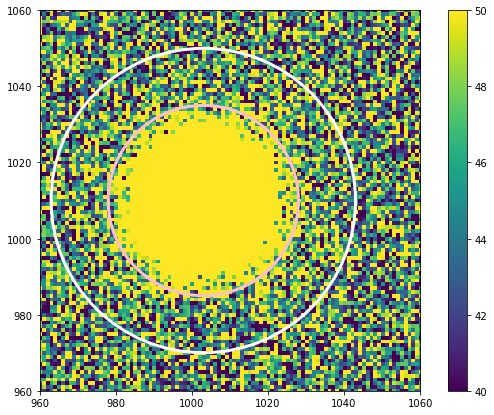

In [14]:
# approx. the aperature radius and the sky annulus by eye
figure, axes = plt.subplots(figsize=(10,7))
plt.imshow(calib_data,cmap='viridis')
plt.clim(40,50)
plt.ylim(960,1060)
plt.xlim(960,1060)
plt.colorbar()
circ = plt.Circle((1003,1010),radius=40,edgecolor='white',facecolor='none',fill='False',lw=3) # sky annulus
circ2 = plt.Circle((1003,1010),radius=25,edgecolor='pink',facecolor='none',fill='False',lw=3) # aperature
axes.add_artist(circ)
axes.add_artist(circ2)
plt.show()

The above is just to get the radii of the aperture and the annulus by eye. Use this to calculate the source flux and its error.

In [15]:
# get axes info from this file
wcs = WCS(hdul[0].header)
naxis = wcs._naxis
x = np.arange(naxis[0])
y = np.arange(naxis[1])

ap = [] # list of pixels within the aperture
an = [] # list of pixels in the sky annulus but not in the aperture

# extract all pixels from the aperture
for x in np.arange(naxis[0]):
    for y in np.arange(naxis[1]):
        if ((x-1003)**2 + (y-1010)**2) <= 25**2:
            ap.append(calib_data[x,y])
            
        if ((((x-1003)**2 + (y-1010)**2) > 25**2) and (((x-1003)**2 + (y-1010)**2) <= 40**2)):
            an.append(calib_data[x,y])

In [53]:
# get the median value and standard deviation of the pixels in the sky annulus
median_an = np.median(an)
stdev_an = np.std(an)
print('Median:',median_an)
print('Stdev:',stdev_an)

# get the source flux by subtracting the background (sky) counts from the sum of the source pixels
source_flux = np.sum(ap) - median_an*len(ap)
print('Source flux (in counts) is:',source_flux)

# get the error on the source flux
def flux_err(S, n_src, n_sky, B):
    """ S = source counts (median times number)
        B = background sky counts (median times number)
        G = gain = 2.15
        n = number of pixels
    """

    G = 2.15
    err = np.sqrt((S/G)+(1+n_src/n_sky)*(B/G))
    return(err)

err = flux_err(S=np.median(ap)*len(ap),n_src=len(ap),n_sky=len(an),B=median_an*len(ap))
print('Source flux error (in counts) is:',err)

Median: 46.64811743185976
Stdev: 7.820982541242063
Source flux (in counts) is: 306284.54164039873
Source flux error (in counts) is: 360.76851540661227


## (5) Plot the light curve of the asteroid overtime.

Define a function that will find the brightest pixel in the source.

In [75]:
def bright_pix(calib_data):
    
    # trim the axes to contain mostly just the source
    calib_trim = calib_data[960:1061,960:1061]

    # collect the x-axis, y-axis, and pixel values
    pix = []
    x_coord = []
    y_coord = []
    for i in range(960,1061):
        for j in range(960,1061):
            pix.append(calib_data[i,j])
            x_coord.append(i)
            y_coord.append(j)

    # find the maximum using pandas
    test = pd.DataFrame()
    test['pix'] = pix
    test['x_coord'] = x_coord
    test['y_coord'] = y_coord
    max_test = test[test['pix'] == max(test['pix'])]

    max_x = int(max_test['x_coord'])
    max_y = int(max_test['y_coord'])
    
    return(max_x, max_y)

Define a function that will calibrate the image (from #3).

In [76]:
def calibrate(hdul_dat, master_bias, master_flat):
    raw_data = hdul_dat
    calib_data = (raw_data - master_bias)/master_flat
    return(calib_data)

Define a function that will compute the source flux and error (from #4).

In [77]:
def flux(calib_data):
    
    # call bright_pix to get the center of the aperture
    x_center, y_center = bright_pix(calib_data)

    ap = [] # list of pixels within the aperture
    an = [] # list of pixels in the sky annulus but not in the aperture

    # extract all pixels from the aperture
    for x in np.arange(960,1061):
        for y in np.arange(960,1061):
            if ((x-x_center)**2 + (y-y_center)**2) <= 25**2:
                ap.append(calib_data[x,y])

            if ((((x-x_center)**2 + (y-y_center)**2) > 25**2) and (((x-x_center)**2 + (y-y_center)**2) <= 40**2)):
                an.append(calib_data[x,y])
                
    # get the median value and standard deviation of the pixels in the sky annulus
    median_an = np.median(an)
    stdev_an = np.std(an)

    # get the source flux by subtracting the background (sky) counts from the sum of the source pixels
    source_flux = np.sum(ap) - median_an*len(ap)

    # get the flux error
    err = flux_err(S=np.median(ap)*len(ap),n_src=len(ap),n_sky=len(an),B=median_an*len(ap))
                
    return(source_flux, err)

In [78]:
# do not look at this it is so inefficient but oh well
data_exts = [141,213,275,335,397,471,547] + list(np.arange(119, 139, step=1)) + list(np.arange(143,170, step=1)) + list(np.arange(196,211, step=1)) + list(np.arange(215,273, step=1)) + list(np.arange(277,333 ,step=1))+ list(np.arange(337,395 ,step=1)) + list(np.arange(425,469 ,step=1)) + list(np.arange(473,509 ,step=1))+ list(np.arange(535,545 ,step=1)) + list(np.arange(549,577 ,step=1))
data_exts = np.sort(data_exts)


In [80]:
# put it all together...

fluxes = []
errs   = []
times  = []

bar = ProgressBar(len(data_exts), ipython_widget=True)
for ext in data_exts:
    
    # open the file and get naxis and time info
    hdul = fits.open('180206_robo/180206.%s' % ext)
    hdul_dat = hdul[0].data
    hdr = hdul[0].header
    hdul.close()
    times.append(hdr['UT'])
    
    # calibrate the data
    calib_data = calibrate(hdul_dat, master_bias, master_flat)
    
    # calculate the source flux and its error
    source_flux, err = flux(calib_data)
    
    fluxes.append(source_flux)
    errs.append(err)
    
    bar.update()

FloatProgress(value=0.0)

In [112]:
time_hrs = []
for i in range(len(times)):
    hours = times[i].split(':')[0]
    mins = times[i].split(':')[1]
    secs = times[i].split(':')[2]
    time_hrs.append(float(hours) + float(mins)/60. + float(secs)/3600)


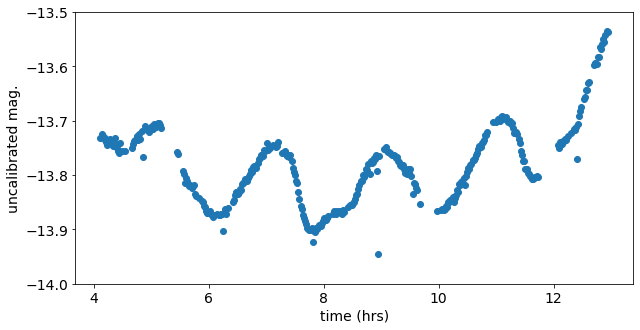

In [139]:
plt.figure(figsize=(10,5))
plt.scatter(time_hrs,-2.5*np.log10(fluxes))
plt.ylim(-14,-13.5)
plt.xlabel('time (hrs)',fontsize=14)
plt.ylabel('uncalibrated mag.',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()